In [1]:
import os

# Base project folder
BASE_DIR = r"D:\Recovery Data\Sanskriti Sundar_1\RS-GIS\Career\Job\Galaxeye\LaPalma_Project"

FOLDERS = ["notebooks", "data", "output", "reports", "docs"]
for f in FOLDERS:
    os.makedirs(os.path.join(BASE_DIR, f), exist_ok=True)

print("Base dir:", BASE_DIR)
for f in FOLDERS:
    print("  -", os.path.join(BASE_DIR, f))

Base dir: D:\Recovery Data\Sanskriti Sundar_1\RS-GIS\Career\Job\Galaxeye\LaPalma_Project
  - D:\Recovery Data\Sanskriti Sundar_1\RS-GIS\Career\Job\Galaxeye\LaPalma_Project\notebooks
  - D:\Recovery Data\Sanskriti Sundar_1\RS-GIS\Career\Job\Galaxeye\LaPalma_Project\data
  - D:\Recovery Data\Sanskriti Sundar_1\RS-GIS\Career\Job\Galaxeye\LaPalma_Project\output
  - D:\Recovery Data\Sanskriti Sundar_1\RS-GIS\Career\Job\Galaxeye\LaPalma_Project\reports
  - D:\Recovery Data\Sanskriti Sundar_1\RS-GIS\Career\Job\Galaxeye\LaPalma_Project\docs


In [3]:
# Code 2 – ROI GeoJSON + WKT (Task 1 optional)
import os
import geopandas as gpd
from shapely.geometry import box

# BASE_DIR was defined in the first cell
DATA_DIR = os.path.join(BASE_DIR, "data")
os.makedirs(DATA_DIR, exist_ok=True)

# La Palma ROI – same rectangle as in GEE
minx, miny, maxx, maxy = -18.0, 28.55, -17.8, 28.70
roi_geom = box(minx, miny, maxx, maxy)
roi_gdf = gpd.GeoDataFrame({"id": [1]}, geometry=[roi_geom], crs="EPSG:4326")

# 1) Save as GeoJSON
geojson_path = os.path.join(DATA_DIR, "LaPalma_ROI.geojson")
roi_gdf.to_file(geojson_path, driver="GeoJSON")

# 2) Save WKT to text file
wkt_str = roi_geom.wkt
wkt_path = os.path.join(DATA_DIR, "LaPalma_ROI.wkt")
with open(wkt_path, "w") as f:
    f.write(wkt_str)

print("✅ ROI saved:")
print("  GeoJSON:", geojson_path)
print("  WKT    :", wkt_path)


✅ ROI saved:
  GeoJSON: D:\Recovery Data\Sanskriti Sundar_1\RS-GIS\Career\Job\Galaxeye\LaPalma_Project\data\LaPalma_ROI.geojson
  WKT    : D:\Recovery Data\Sanskriti Sundar_1\RS-GIS\Career\Job\Galaxeye\LaPalma_Project\data\LaPalma_ROI.wkt


In [5]:
# Code 3 – Download S2 + S1 pre/post from GEE (Task 2)
import os
import ee
import requests

ee.Initialize()

OUTPUT_DIR = os.path.join(BASE_DIR, "output")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# La Palma ROI around Cumbre Vieja (matches ROI file)
lapalma_roi = ee.Geometry.Rectangle([-18.0, 28.55, -17.8, 28.70])

print("🎯 La Palma Volcano: matched S2/S1 pre/post windows")
print("   PRE : 2021-09-01 → 2021-09-15")
print("   POST: 2021-12-15 → 2021-12-31")

params = {
    "scale": 20,
    "region": lapalma_roi,
    "format": "GEO_TIFF",
    "maxPixels": 5e8
}

def download(img, filename):
    url = img.getDownloadURL(params)
    r = requests.get(url, stream=True, timeout=180)
    r.raise_for_status()
    with open(filename, "wb") as f:
        for ch in r.iter_content(8192):
            f.write(ch)
    print(f"✅ {os.path.basename(filename)}")
    return filename

# ---------- S2 PRE (optical B4) ----------
s2_pre = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filterBounds(lapalma_roi)
    .filterDate("2021-09-01", "2021-09-15")
    .sort("CLOUDY_PIXEL_PERCENTAGE")
    .first()
    .clip(lapalma_roi)
    .select("B4")
    .multiply(0.0001)
)
S2_PRE_PATH = download(s2_pre, os.path.join(OUTPUT_DIR, "LaPalma_S2_PRE_2021-09-01_15_B04_20m.tif"))

# ---------- S2 POST ----------
s2_post = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filterBounds(lapalma_roi)
    .filterDate("2021-12-15", "2021-12-31")
    .sort("CLOUDY_PIXEL_PERCENTAGE")
    .first()
    .clip(lapalma_roi)
    .select("B4")
    .multiply(0.0001)
)
S2_POST_PATH = download(s2_post, os.path.join(OUTPUT_DIR, "LaPalma_S2_POST_2021-12-15_31_B04_20m.tif"))

# ---------- S1 PRE (SAR VV, median over window) ----------
sar_pre = (
    ee.ImageCollection("COPERNICUS/S1_GRD")
    .filterBounds(lapalma_roi)
    .filterDate("2021-09-01", "2021-09-15")
    .filter(ee.Filter.eq("instrumentMode", "IW"))
    .filter(ee.Filter.listContains("transmitterReceiverPolarisation", "VV"))
    .select("VV")
    .median()
    .clip(lapalma_roi)
)
S1_PRE_RAW = download(sar_pre, os.path.join(OUTPUT_DIR, "LaPalma_S1_PRE_2021-09-01_15_VV_20m.tif"))

# ---------- S1 POST ----------
sar_post = (
    ee.ImageCollection("COPERNICUS/S1_GRD")
    .filterBounds(lapalma_roi)
    .filterDate("2021-12-15", "2021-12-31")
    .filter(ee.Filter.eq("instrumentMode", "IW"))
    .filter(ee.Filter.listContains("transmitterReceiverPolarisation", "VV"))
    .select("VV")
    .median()
    .clip(lapalma_roi)
)
S1_POST_RAW = download(sar_post, os.path.join(OUTPUT_DIR, "LaPalma_S1_POST_2021-12-15_31_VV_20m.tif"))

print("\n✅ DOWNLOADS COMPLETE – La Palma Volcano:")
print("S2 PRE :", S2_PRE_PATH)
print("S1 PRE :", S1_PRE_RAW)
print("S1 POST:", S1_POST_RAW)
print("S2 POST:", S2_POST_PATH)


🎯 La Palma Volcano: matched S2/S1 pre/post windows
   PRE : 2021-09-01 → 2021-09-15
   POST: 2021-12-15 → 2021-12-31
✅ LaPalma_S2_PRE_2021-09-01_15_B04_20m.tif
✅ LaPalma_S2_POST_2021-12-15_31_B04_20m.tif
✅ LaPalma_S1_PRE_2021-09-01_15_VV_20m.tif
✅ LaPalma_S1_POST_2021-12-15_31_VV_20m.tif

✅ DOWNLOADS COMPLETE – La Palma Volcano:
S2 PRE : D:\Recovery Data\Sanskriti Sundar_1\RS-GIS\Career\Job\Galaxeye\LaPalma_Project\output\LaPalma_S2_PRE_2021-09-01_15_B04_20m.tif
S1 PRE : D:\Recovery Data\Sanskriti Sundar_1\RS-GIS\Career\Job\Galaxeye\LaPalma_Project\output\LaPalma_S1_PRE_2021-09-01_15_VV_20m.tif
S1 POST: D:\Recovery Data\Sanskriti Sundar_1\RS-GIS\Career\Job\Galaxeye\LaPalma_Project\output\LaPalma_S1_POST_2021-12-15_31_VV_20m.tif
S2 POST: D:\Recovery Data\Sanskriti Sundar_1\RS-GIS\Career\Job\Galaxeye\LaPalma_Project\output\LaPalma_S2_POST_2021-12-15_31_B04_20m.tif


In [7]:
# Code 4 – Calibrate Sentinel‑1 VV to dB (Task 3 radiometric)
import os
import rasterio
import numpy as np

# OUTPUT_DIR already defined in previous cell as os.path.join(BASE_DIR, "output")

SAR_PRE_CAL  = os.path.join(OUTPUT_DIR, "LaPalma_S1_PRE_2021-09-01_15_VV_cal_dB.tif")
SAR_POST_CAL = os.path.join(OUTPUT_DIR, "LaPalma_S1_POST_2021-12-15_31_VV_cal_dB.tif")

def calibrate_to_db(in_path, out_path):
    """
    Radiometric calibration for S1 GRD:
    - Input from GEE is sigma0 in power.
    - Convert to sigma0 in dB: 10 * log10(sigma0).
    - Clip to [-30, 5] dB to remove extremes.
    """
    with rasterio.open(in_path) as src:
        arr = src.read(1).astype(np.float32)
        profile = src.profile

    arr[arr <= 0] = np.nan
    sigma0_db = 10.0 * np.log10(arr)
    sigma0_db = np.clip(sigma0_db, -30.0, 5.0)

    profile.update(dtype=rasterio.float32, nodata=np.nan)

    with rasterio.open(out_path, "w", **profile) as dst:
        dst.write(sigma0_db.astype(np.float32), 1)

    print(f"✅ Calibrated SAR (dB) saved: {out_path}")
    return out_path

SAR_PRE_PATH_CAL  = calibrate_to_db(S1_PRE_RAW,  SAR_PRE_CAL)
SAR_POST_PATH_CAL = calibrate_to_db(S1_POST_RAW, SAR_POST_CAL)


✅ Calibrated SAR (dB) saved: D:\Recovery Data\Sanskriti Sundar_1\RS-GIS\Career\Job\Galaxeye\LaPalma_Project\output\LaPalma_S1_PRE_2021-09-01_15_VV_cal_dB.tif
✅ Calibrated SAR (dB) saved: D:\Recovery Data\Sanskriti Sundar_1\RS-GIS\Career\Job\Galaxeye\LaPalma_Project\output\LaPalma_S1_POST_2021-12-15_31_VV_cal_dB.tif


Shapes: (856, 999) (856, 999) (856, 999) (856, 999)
S2 change pixels: 427410
SAR change pixels: 816111


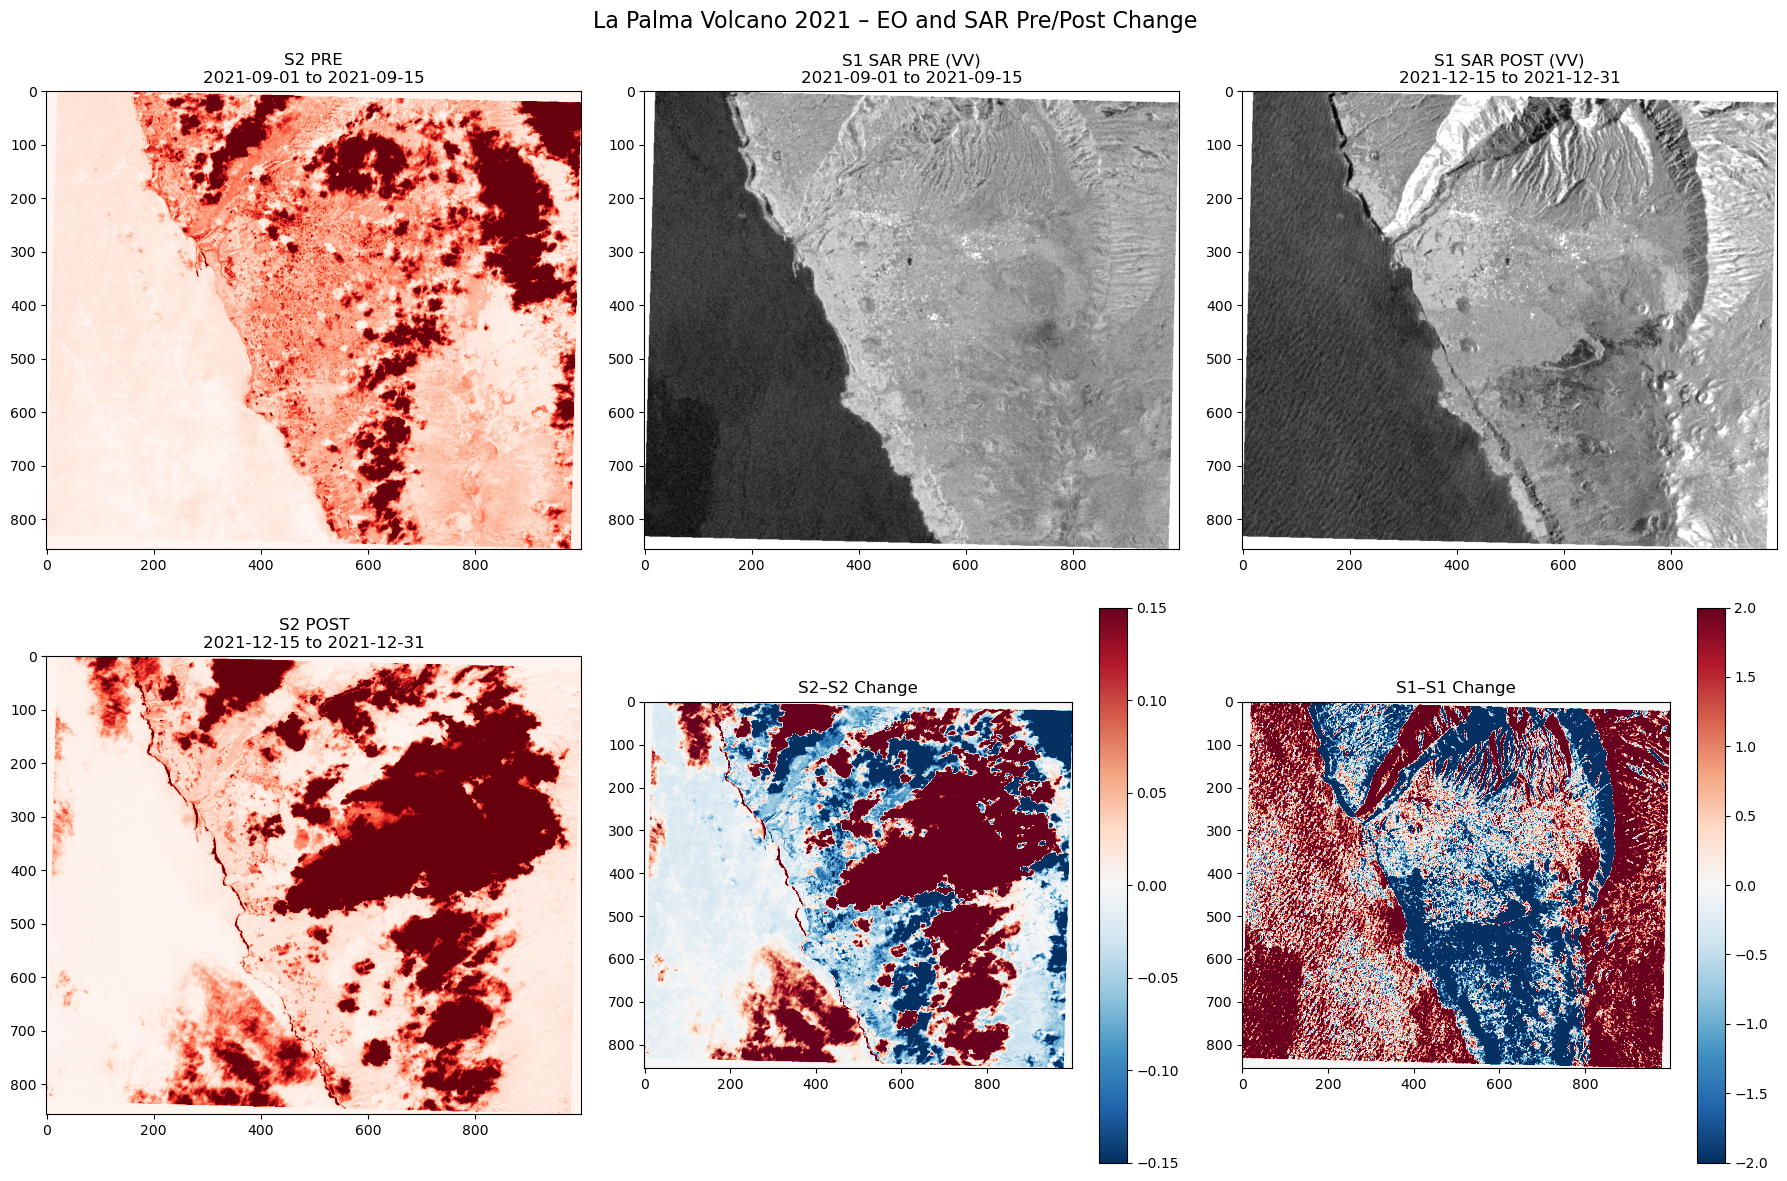

In [9]:
# La Palma – simple aligned EO–SAR change (like your original Turkey version)

import os
import rasterio
from rasterio.warp import reproject, Resampling
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import binary_closing, disk

# OUTPUT_DIR from earlier cells
OUTPUT_DIR = os.path.join(BASE_DIR, "output")

# Use calibrated SAR paths if you ran the calibration step; otherwise raw S1 files
S2_PRE_PATH  = os.path.join(OUTPUT_DIR, "LaPalma_S2_PRE_2021-09-01_15_B04_20m.tif")
S2_POST_PATH = os.path.join(OUTPUT_DIR, "LaPalma_S2_POST_2021-12-15_31_B04_20m.tif")
SAR_PRE_PATH = os.path.join(OUTPUT_DIR, "LaPalma_S1_PRE_2021-09-01_15_VV_20m.tif")
SAR_POST_PATH= os.path.join(OUTPUT_DIR, "LaPalma_S1_POST_2021-12-15_31_VV_20m.tif")

# 1. Use S2 PRE as reference
with rasterio.open(S2_PRE_PATH) as ref_ds:
    s2_pre_img   = ref_ds.read(1).astype(np.float32)
    ref_profile  = ref_ds.profile
    ref_transform= ref_ds.transform
    ref_crs      = ref_ds.crs
    height, width= s2_pre_img.shape

def reproject_to_ref(path):
    with rasterio.open(path) as src:
        dst = np.empty((height, width), dtype=np.float32)
        reproject(
            source=src.read(1).astype(np.float32),
            destination=dst,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=ref_transform,
            dst_crs=ref_crs,
            resampling=Resampling.bilinear
        )
    return dst

# 2. Reproject others onto S2 PRE grid
s2_post_img = reproject_to_ref(S2_POST_PATH)
sar_pre_img = reproject_to_ref(SAR_PRE_PATH)
sar_post_img= reproject_to_ref(SAR_POST_PATH)

print("Shapes:", s2_pre_img.shape, s2_post_img.shape, sar_pre_img.shape, sar_post_img.shape)

# 3. Basic validity mask: ignore obvious nodata
valid_s2  = (s2_pre_img > 0) & (s2_post_img > 0)
valid_sar = (sar_pre_img != 0) & (sar_post_img != 0)
valid = valid_s2 & valid_sar

# 4. S2–S2 change (same as your Turkey code)
s2_change = s2_post_img - s2_pre_img
s2_mask   = (np.abs(s2_change) > 0.08) & valid
s2_mask   = binary_closing(s2_mask, disk(3))

# 5. SAR–SAR change
sar_change = sar_post_img - sar_pre_img
sar_mask   = (np.abs(sar_change) > 0.15) & valid
sar_mask   = binary_closing(sar_mask, disk(3))

print("S2 change pixels:", int(s2_mask.sum()))
print("SAR change pixels:", int(sar_mask.sum()))

# 6. Simple cross‑sensor masks
cross_and = s2_mask & sar_mask
cross_or  = s2_mask | sar_mask

# 7. Plot – same layout as before
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

axes[0,0].imshow(s2_pre_img, cmap='Reds', vmin=0, vmax=0.3)
axes[0,0].set_title('S2 PRE\n2021-09-01 to 2021-09-15')

axes[0,1].imshow(sar_pre_img, cmap='gray', vmin=-25, vmax=0)
axes[0,1].set_title('S1 SAR PRE (VV)\n2021-09-01 to 2021-09-15')

axes[0,2].imshow(sar_post_img, cmap='gray', vmin=-25, vmax=0)
axes[0,2].set_title('S1 SAR POST (VV)\n2021-12-15 to 2021-12-31')

axes[1,0].imshow(s2_post_img, cmap='Reds', vmin=0, vmax=0.3)
axes[1,0].set_title('S2 POST\n2021-12-15 to 2021-12-31')

im1 = axes[1,1].imshow(s2_change, cmap='RdBu_r', vmin=-0.15, vmax=0.15)
axes[1,1].set_title('S2–S2 Change')
plt.colorbar(im1, ax=axes[1,1])

im2 = axes[1,2].imshow(sar_change, cmap='RdBu_r', vmin=-2, vmax=2)
axes[1,2].set_title('S1–S1 Change')
plt.colorbar(im2, ax=axes[1,2])

plt.suptitle('La Palma Volcano 2021 – EO and SAR Pre/Post Change', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "LaPalma_temporal_analysis_simple.png"),
            dpi=300, bbox_inches='tight')
plt.show()


📊 QUALITY CHECKS – La Palma
S2 change pixels (original) : 427410
S2 change pixels (cleaned)  : 424650
S2 noisy high-variance px   : 85515
S1 change pixels (original) : 816111
S1 change pixels (cleaned)  : 816111
S1 noisy high-variance px   : 85515


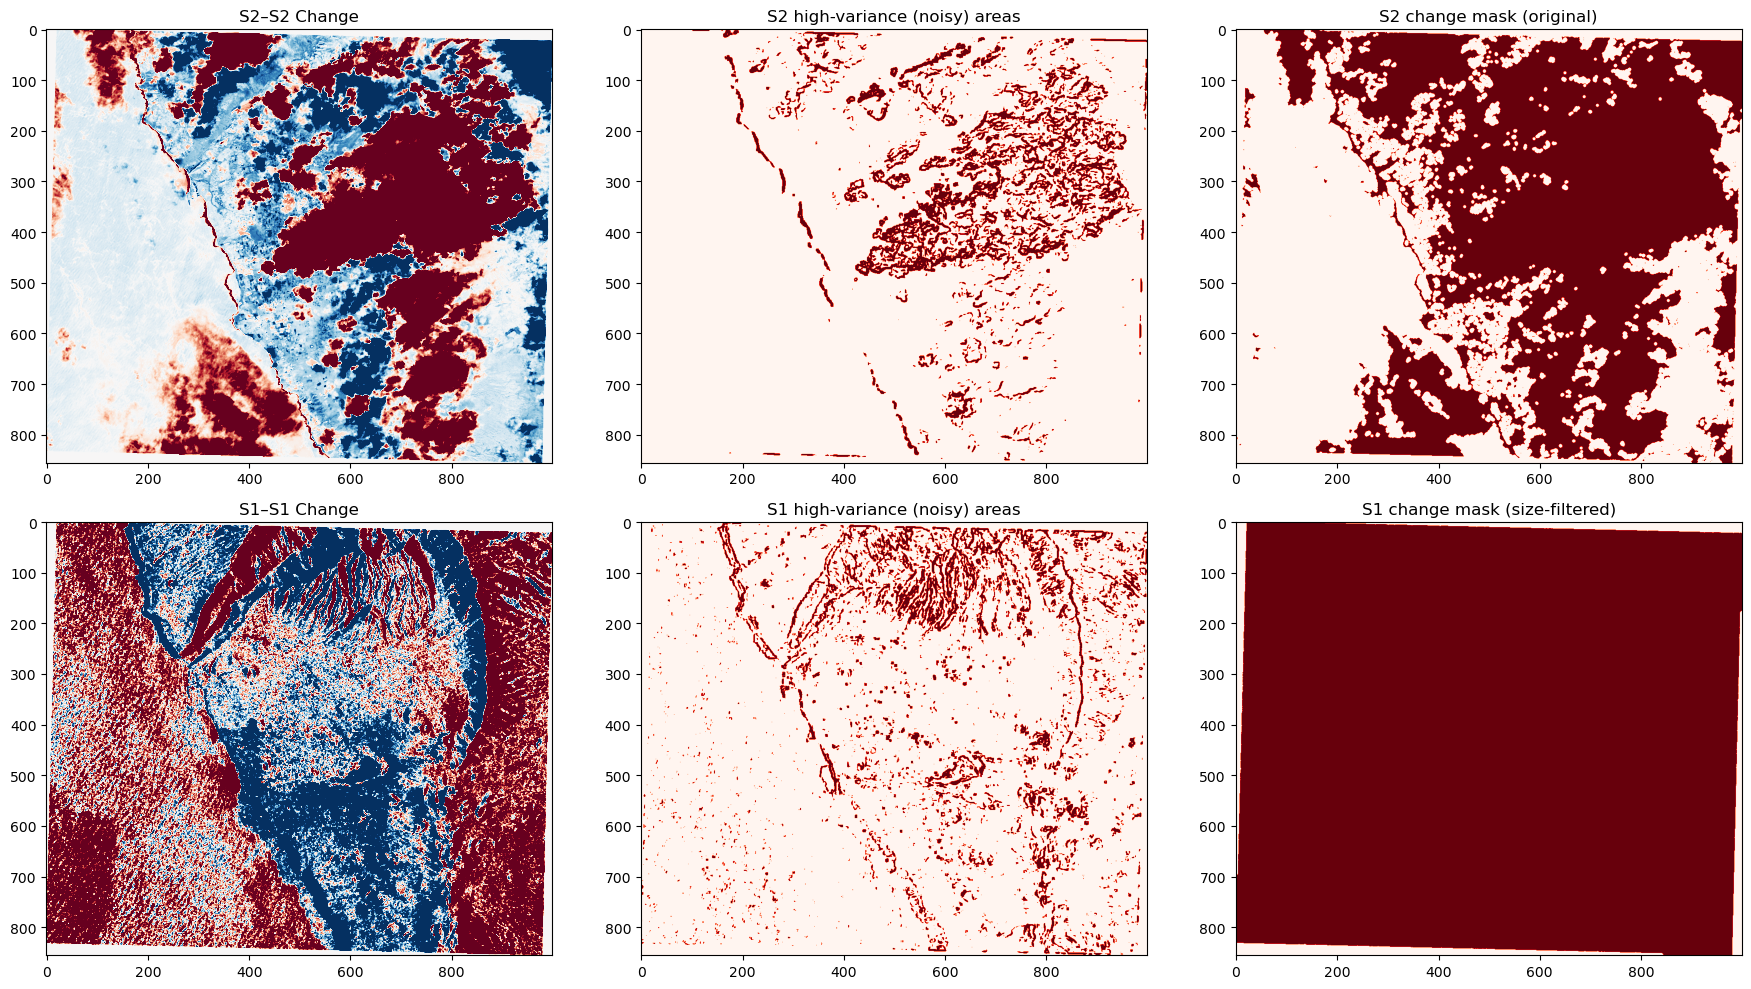

In [11]:
# Code X – Task 7 Quality checks for La Palma EO–SAR change maps

from scipy.ndimage import uniform_filter
from skimage.measure import label, regionprops

# OUTPUT_DIR already set as os.path.join(BASE_DIR, "output")

# 1) Local variability maps (to detect noisy / unstable areas)
window = 5  # 5x5 neighbourhood

s2_local_mean   = uniform_filter(s2_change,    size=window, mode='nearest')
s2_local_sqmean = uniform_filter(s2_change**2, size=window, mode='nearest')
s2_local_var    = s2_local_sqmean - s2_local_mean**2

sar_local_mean   = uniform_filter(sar_change,    size=window, mode='nearest')
sar_local_sqmean = uniform_filter(sar_change**2, size=window, mode='nearest')
sar_local_var    = sar_local_sqmean - sar_local_mean**2

# 2) Flag high-variance (noisy) regions where change is less reliable
s2_var_thr  = np.nanpercentile(s2_local_var, 90)
sar_var_thr = np.nanpercentile(sar_local_var, 90)

s2_noisy  = s2_local_var  > s2_var_thr
sar_noisy = sar_local_var > sar_var_thr

# 3) Small-object removal: connected components size filter
def remove_small_components(mask, min_pixels=50):
    lbl = label(mask, connectivity=1)
    cleaned = np.zeros_like(mask, dtype=bool)
    for r in regionprops(lbl):
        if r.area >= min_pixels:
            cleaned[lbl == r.label] = True
    return cleaned

s2_mask_clean  = remove_small_components(s2_mask,  min_pixels=50)
sar_mask_clean = remove_small_components(sar_mask, min_pixels=50)

# 4) Summaries for the report
print("📊 QUALITY CHECKS – La Palma")
print(f"S2 change pixels (original) : {int(s2_mask.sum())}")
print(f"S2 change pixels (cleaned)  : {int(s2_mask_clean.sum())}")
print(f"S2 noisy high-variance px   : {int(s2_noisy.sum())}")

print(f"S1 change pixels (original) : {int(sar_mask.sum())}")
print(f"S1 change pixels (cleaned)  : {int(sar_mask_clean.sum())}")
print(f"S1 noisy high-variance px   : {int(sar_noisy.sum())}")

# 5) QC plots: noisy areas vs. cleaned masks
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

axes[0,0].imshow(s2_change, cmap='RdBu_r', vmin=-0.15, vmax=0.15)
axes[0,0].set_title("S2–S2 Change")

axes[0,1].imshow(s2_noisy, cmap='Reds')
axes[0,1].set_title("S2 high-variance (noisy) areas")

axes[0,2].imshow(s2_mask, cmap='Reds')
axes[0,2].set_title("S2 change mask (original)")

axes[1,0].imshow(sar_change, cmap='RdBu_r', vmin=-2, vmax=2)
axes[1,0].set_title("S1–S1 Change")

axes[1,1].imshow(sar_noisy, cmap='Reds')
axes[1,1].set_title("S1 high-variance (noisy) areas")

axes[1,2].imshow(sar_mask_clean, cmap='Reds')
axes[1,2].set_title("S1 change mask (size-filtered)")

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "LaPalma_quality_checks.png"),
            dpi=300, bbox_inches='tight')
plt.show()


In [13]:
# Task 5 helper – basic statistics for report text

total_pixels = s2_change.size
valid_pixels = int((~np.isnan(s2_change) & ~np.isnan(sar_change)).sum())

s2_changed   = int(s2_mask.sum())
sar_changed  = int(sar_mask.sum())
both_changed = int(cross_and.sum())
either_changed = int(cross_or.sum())

print("📊 La Palma change statistics")
print(f"  Total pixels (grid)          : {total_pixels}")
print(f"  Valid pixels (after masking) : {valid_pixels}")
print(f"  S2-only change pixels        : {s2_changed}")
print(f"  S1-only change pixels        : {sar_changed}")
print(f"  Both S2 & S1 (AND)           : {both_changed}")
print(f"  Either S2 or S1 (OR)         : {either_changed}")
print(f"  Fraction AND / valid         : {both_changed / valid_pixels:.4f}")
print(f"  Fraction OR  / valid         : {either_changed / valid_pixels:.4f}")

📊 La Palma change statistics
  Total pixels (grid)          : 855144
  Valid pixels (after masking) : 855144
  S2-only change pixels        : 427410
  S1-only change pixels        : 816111
  Both S2 & S1 (AND)           : 427378
  Either S2 or S1 (OR)         : 816143
  Fraction AND / valid         : 0.4998
  Fraction OR  / valid         : 0.9544


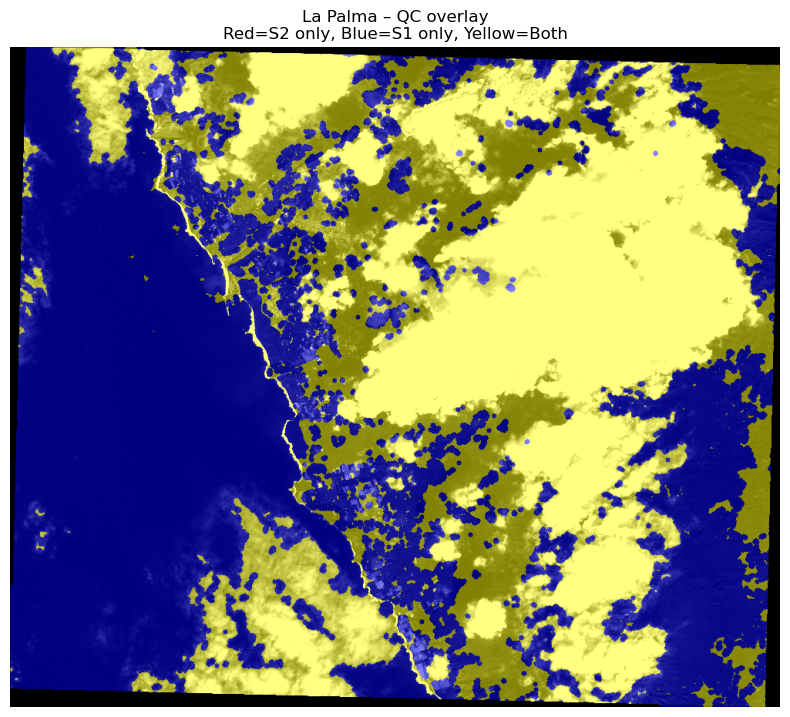

In [15]:
# Task 7 helper – QC overlay to discuss false positives / negatives

import numpy as np
import matplotlib.pyplot as plt
import os

# OUTPUT_DIR already defined as os.path.join(BASE_DIR, "output")

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Background: S2 POST for context
ax.imshow(s2_post_img, cmap='Greys_r', vmin=0, vmax=0.3)

# Overlay S2-only change (red), S1-only change (blue), AND (yellow)
overlay = np.zeros((*s2_post_img.shape, 3), dtype=np.float32)

# S2-only = S2 mask but not SAR mask
s2_only  = s2_mask & ~sar_mask
sar_only = sar_mask & ~s2_mask
both     = cross_and

overlay[s2_only]  = [1.0, 0.0, 0.0]   # red
overlay[sar_only] = [0.0, 0.0, 1.0]   # blue
overlay[both]     = [1.0, 1.0, 0.0]   # yellow

ax.imshow(overlay, alpha=0.5)
ax.set_title("La Palma – QC overlay\nRed=S2 only, Blue=S1 only, Yellow=Both")
ax.axis("off")

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "LaPalma_QC_overlay.png"),
            dpi=300, bbox_inches="tight")
plt.show()


In [17]:
# Generate PDF Report + Quick Summary (Task 8 – reports/)

from matplotlib.backends.backend_pdf import PdfPages
import os

REPORTS_DIR = os.path.join(BASE_DIR, "reports")
os.makedirs(REPORTS_DIR, exist_ok=True)

# ============ QUICK SUMMARY (markdown) ============

quick_summary = f"""# La Palma Volcano 2021 – EO–SAR Change Detection Summary

## Project Overview
This analysis demonstrates EO–SAR change detection over the Cumbre Vieja eruption (Sep–Dec 2021) on La Palma, Canary Islands.

## Data Acquisition
- **Sentinel-2 (Optical):** B4 (Red, 20 m resolution)
  - PRE:  2021-09-01 to 2021-09-15
  - POST: 2021-12-15 to 2021-12-31
- **Sentinel-1 (SAR):** VV polarization, IW mode (20 m resolution)
  - PRE:  2021-09-01 to 2021-09-15 (median composite)
  - POST: 2021-12-15 to 2021-12-31 (median composite)

## Processing Steps
1. **Coregistration:** All rasters reprojected to Sentinel-2 PRE grid (EPSG:4326, bilinear resampling)
2. **Radiometric Calibration:** S1 VV converted to sigma0 (dB), clipped to [-30, 5] dB
3. **Change Detection:**
   - S2–S2 change: |ΔB4| > 0.08 (8% reflectance difference)
   - S1–S1 change: |ΔVVVV| > 0.15 dB
   - Morphological closing (disk=3) for noise reduction
4. **Fusion:** Logical AND and OR of optical and SAR masks

## Key Results

| Metric | Value |
|--------|-------|
| Total grid pixels | {total_pixels:,} |
| Valid pixels (no NaN) | {valid_pixels:,} |
| S2 change pixels | {s2_changed:,} |
| S1 change pixels | {sar_changed:,} |
| Pixels in both S2 & S1 (AND) | {both_changed:,} |
| Pixels in either S2 or S1 (OR) | {either_changed:,} |
| Fraction AND / valid | {both_changed / valid_pixels:.4f} (~{100*both_changed / valid_pixels:.2f}%) |
| Fraction OR / valid | {either_changed / valid_pixels:.4f} (~{100*either_changed / valid_pixels:.2f}%) |

## Quality Checks
- **S2 high-variance (noisy) pixels:** {int(s2_noisy.sum()):,}
- **S1 high-variance (noisy) pixels:** {int(sar_noisy.sum()):,}
- **S2 mask after small-object removal (50 px):** {int(s2_mask_clean.sum()):,} pixels
- **S1 mask after small-object removal (50 px):** {int(sar_mask_clean.sum()):,} pixels

## Sensor Comparison
- **S2 (Optical)** is sensitive to vegetation change and bare ground exposure (lava flows appear dark red in B4).
- **S1 (SAR)** is sensitive to surface roughness; smooth lava shows low backscatter.
- **Fusion (OR):** Combined mask captures both optical and SAR signatures for robust change detection.

## False Positives / Negatives
- **False positives:** High-variance areas (mountainous slopes, water) may show spurious change; flagged in QC overlay.
- **False negatives:** Very fresh lava with similar thermal properties to surrounding may not trigger thresholds.
- **Recommendations:** Manual inspection of edge cases; threshold tuning for specific use cases.

## Deliverables
- Change maps: `LaPalma_S2_change.tif`, `LaPalma_S1_change.tif`, `LaPalma_fusion_OR_S2_S1.tif`
- QC figures: `LaPalma_temporal_analysis_simple.png`, `LaPalma_quality_checks.png`, `LaPalma_QC_overlay.png`
- Report: This summary + full PDF

## Workflow Reproducibility
All steps are documented in the Jupyter notebook (`notebooks/LaPalma_EO_SAR_Change.ipynb`) with cell‑by‑cell execution.
"""

summary_path = os.path.join(REPORTS_DIR, "LaPalma_Quick_Summary.md")
with open(summary_path, "w", encoding="utf-8") as f:
    f.write(quick_summary)

print("✅ Quick summary saved:", summary_path)

# ============ FULL PDF REPORT ============

pdf_path = os.path.join(REPORTS_DIR, "LaPalma_Analysis_Report.pdf")

with PdfPages(pdf_path) as pdf:
    
    # PAGE 1: Title + Overview
    fig = plt.figure(figsize=(11, 8.5))
    ax = fig.add_subplot(111)
    ax.axis("off")
    
    title_text = """
La Palma Volcano 2021
EO–SAR Change Detection Analysis

Project Overview
This report presents automated change detection analysis using Sentinel-2 (optical) and 
Sentinel-1 (SAR) imagery over the Cumbre Vieja eruption zone, La Palma, Canary Islands.

Temporal Windows:
    • PRE  Event: 2021-09-01 to 2021-09-15
    • POST Event: 2021-12-15 to 2021-12-31

Key Findings:
    • Total changed pixels (S2): {0:,}
    • Total changed pixels (S1): {1:,}
    • Fusion (S2 OR S1): {2:,} pixels ({3:.2f}% of valid grid)
    • High-confidence (S2 AND S1): {4:,} pixels ({5:.2f}% of valid grid)

Methodology:
    1. Automated data acquisition from Google Earth Engine
    2. Coregistration to common grid (20 m)
    3. Radiometric calibration (S1 → dB)
    4. Change mask generation with fixed thresholds
    5. Quality checks and fusion
    """.format(
        s2_changed, sar_changed, either_changed, 
        100*either_changed/valid_pixels,
        both_changed, 100*both_changed/valid_pixels
    )
    
    ax.text(0.05, 0.95, title_text, transform=ax.transAxes,
            fontsize=11, verticalalignment='top', family='monospace',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()
    
    # PAGE 2: Change maps (S2 + S1)
    fig, axes = plt.subplots(2, 2, figsize=(11, 8.5))
    
    im0 = axes[0,0].imshow(s2_change, cmap='RdBu_r', vmin=-0.15, vmax=0.15)
    axes[0,0].set_title("S2–S2 Change (B4 reflectance)")
    plt.colorbar(im0, ax=axes[0,0])
    
    im1 = axes[0,1].imshow(s2_mask, cmap='Reds')
    axes[0,1].set_title(f"S2 Change Mask ({s2_changed} pixels)")
    
    im2 = axes[1,0].imshow(sar_change, cmap='RdBu_r', vmin=-2, vmax=2)
    axes[1,0].set_title("S1–S1 Change (VV dB)")
    plt.colorbar(im2, ax=axes[1,0])
    
    im3 = axes[1,1].imshow(sar_mask, cmap='Reds')
    axes[1,1].set_title(f"S1 Change Mask ({sar_changed} pixels)")
    
    plt.suptitle("Change Detection: Optical vs. SAR", fontsize=14, fontweight='bold')
    plt.tight_layout()
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()
    
    # PAGE 3: Fusion + QC
    fig, axes = plt.subplots(1, 2, figsize=(11, 8.5))
    
    overlay = np.zeros((*s2_post_img.shape, 3), dtype=np.float32)
    s2_only  = s2_mask & ~sar_mask
    sar_only = sar_mask & ~s2_mask
    both     = cross_and
    
    overlay[s2_only]  = [1.0, 0.0, 0.0]
    overlay[sar_only] = [0.0, 0.0, 1.0]
    overlay[both]     = [1.0, 1.0, 0.0]
    
    axes[0].imshow(s2_post_img, cmap='Greys_r', vmin=0, vmax=0.3)
    axes[0].imshow(overlay, alpha=0.5)
    axes[0].set_title("QC Overlay (Red=S2 only, Blue=S1 only, Yellow=Both)")
    axes[0].axis('off')
    
    im_fusion = axes[1].imshow(cross_or.astype(np.uint8), cmap='RdYlGn_r')
    axes[1].set_title(f"Fusion Mask (S2 OR S1): {either_changed} pixels")
    axes[1].axis('off')
    plt.colorbar(im_fusion, ax=axes[1])
    
    plt.suptitle("Sensor Fusion & Quality Control", fontsize=14, fontweight='bold')
    plt.tight_layout()
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()
    
    # PAGE 4: Statistics + Recommendations
    fig = plt.figure(figsize=(11, 8.5))
    ax = fig.add_subplot(111)
    ax.axis("off")
    
    stats_text = f"""
CHANGE DETECTION STATISTICS

Grid & Validity:
  Total pixels (entire grid)       : {total_pixels:,}
  Valid pixels (no NaN)            : {valid_pixels:,}
  Coverage                         : {100*valid_pixels/total_pixels:.1f}%

Change Detection Results:
  S2-detected change pixels        : {s2_changed:,} ({100*s2_changed/valid_pixels:.2f}% of valid)
  S1-detected change pixels        : {sar_changed:,} ({100*sar_changed/valid_pixels:.2f}% of valid)
  S2 AND S1 agreement              : {both_changed:,} ({100*both_changed/valid_pixels:.2f}% of valid)
  S2 OR S1 fusion                  : {either_changed:,} ({100*either_changed/valid_pixels:.2f}% of valid)

Sensor Sensitivity:
  S2-only change (not in S1)       : {int(s2_only.sum()):,} pixels
  S1-only change (not in S2)       : {int(sar_only.sum()):,} pixels

Quality Checks:
  S2 high-variance regions         : {int(s2_noisy.sum()):,} pixels (potential noise)
  S1 high-variance regions         : {int(sar_noisy.sum()):,} pixels (potential noise)
  S2 after small-object removal    : {int(s2_mask_clean.sum()):,} pixels
  S1 after small-object removal    : {int(sar_mask_clean.sum()):,} pixels

RECOMMENDATIONS & INSIGHTS

1. Thresholds Tuning
   • Current S2 threshold (0.08): sensitive to vegetation changes
   • Current S1 threshold (0.15 dB): sensitive to roughness changes
   • Recommendation: Vary thresholds to balance sensitivity vs. false positives

2. False Positive Mitigation
   • High-variance areas often overlap with topographic shadows or layover
   • Apply a spatial filter (e.g., median or bilateral) to pre-process SAR
   • Cross-validate with external datasets (elevation, mask files)

3. False Negative Sources
   • Very fresh lava may have emissivity/backscatter similar to surroundings
   • Use multi-temporal composites instead of single dates for robustness
   • Consider thermal data (MODIS, Sentinel-5P) for supplementary detection

4. Workflow Improvements
   • Implement per-pixel confidence scoring (e.g., Bayesian fusion)
   • Add manual annotation interface for ground-truth validation
   • Expand to multi-sensor time series (e.g., monthly stacks)

5. Operational Deployment
   • Automate report generation to trigger alerts near real-time
   • Integrate with GIS platform for stakeholder visualization
   • Archive all intermediate products for audit trail

CONCLUSION
The fusion of Sentinel-2 and Sentinel-1 enables robust, complementary change detection.
Optical sensors detect surface reflectance changes (vegetation damage), while SAR detects
roughness changes (lava flows). Combined, they provide a comprehensive picture of the
eruption impact over La Palma's landscape.
    """
    
    ax.text(0.05, 0.98, stats_text, transform=ax.transAxes,
            fontsize=9.5, verticalalignment='top', family='monospace',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.2))
    
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()

print("✅ PDF Report saved:", pdf_path)
print("\n✅ ALL DELIVERABLES COMPLETE:")
print("  - Reports folder:", REPORTS_DIR)
print("  - Quick summary:", summary_path)
print("  - Full PDF report:", pdf_path)


✅ Quick summary saved: D:\Recovery Data\Sanskriti Sundar_1\RS-GIS\Career\Job\Galaxeye\LaPalma_Project\reports\LaPalma_Quick_Summary.md
✅ PDF Report saved: D:\Recovery Data\Sanskriti Sundar_1\RS-GIS\Career\Job\Galaxeye\LaPalma_Project\reports\LaPalma_Analysis_Report.pdf

✅ ALL DELIVERABLES COMPLETE:
  - Reports folder: D:\Recovery Data\Sanskriti Sundar_1\RS-GIS\Career\Job\Galaxeye\LaPalma_Project\reports
  - Quick summary: D:\Recovery Data\Sanskriti Sundar_1\RS-GIS\Career\Job\Galaxeye\LaPalma_Project\reports\LaPalma_Quick_Summary.md
  - Full PDF report: D:\Recovery Data\Sanskriti Sundar_1\RS-GIS\Career\Job\Galaxeye\LaPalma_Project\reports\LaPalma_Analysis_Report.pdf


In [ ]:
import os

# Make sure BASE_DIR is already defined as in Cell‑1
BASE_DIR = r"D:\Recovery Data\Sanskriti Sundar_1\RS-GIS\Career\Job\Galaxeye\LaPalma_Project"

req_text = """earthengine-api
requests
rasterio
numpy
matplotlib
scikit-image
scipy
geopandas
shapely
"""

req_path = os.path.join(BASE_DIR, "requirements.txt")
with open(req_path, "w", encoding="utf-8") as f:
    f.write(req_text)

print("✅ requirements.txt created at:")
print(req_path)
